<a href="https://colab.research.google.com/github/moch1996/Vaycold/blob/main/Python_DL/%EC%97%AC%EB%9F%AC%20%EC%9D%98%EC%83%81%20%EC%82%AC%EC%A7%84%EC%97%90%EC%84%9C%20%EC%98%B7%20%EC%A2%85%EB%A5%98%20%EA%B5%AC%EB%B6%84%ED%95%98%EA%B8%B0~2%EC%B0%A8%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이번 학습의 방향
    1차 모델링결과 메모리 문제로 코랩에서 더 진행할 수가 없기에 
    데이터크기를 줄인 후 다시 모델링을 해보려고 한다.

## Library

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, MaxPool2D, Conv2D, Dropout, Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import to_categorical


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image
from google.colab import drive

warnings.filterwarnings('ignore')

SEED=34

In [4]:
# 딱히 필요는 없는 듯 하다..
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

## 지난 번 생성했던 함수들

In [5]:
def idx2label(idx) :
  return labels[idx]

In [6]:
# 이미지 한장의 크기를 4배로 확대하고, 객체는 4분면 영역중 랜덤으로 1공간에 넣는 함수를 작성해보자

def expand(img) :
  bg = np.zeros(img.shape)
  # 1 0
  # 2 3
  idx = np.random.randint(0,4)
  slots = [bg,bg,bg,bg]
  slots[idx] = img
  expanded = np.vstack([
                        np.hstack(slots[:2]), 
                        np.hstack(slots[2:])
                        
  ]
  )
  return expanded

In [7]:

def expand_4times(x_data,y_data) :
  images = []
  labels = []

  for _ in range(4) :
    bg = np.zeros((28,28))
    obj_count = np.random.randint(0,5)

    label = np.zeros((10,))
    slots = [bg, bg,bg,bg]

    for idx in range(obj_count) :
      i = np.random.randint(len(x_data))
      slots[idx] = x_data[i]
      label += tf.keras.utils.to_categorical(y_data[i],10)
    
    np.random.shuffle(slots)
  
  new_img = np.vstack([
                       np.hstack(slots[:2]),
                       np.hstack(slots[2:])
  ])

  images.append(new_img)
  labels.append((label >=1).astype(np.int))
  return np.array(images), np.array(labels)

In [8]:
'''
있으면 편리할 거 같지만 필수는 아닐 거 같은...

def final(n) :
  res = model2.predict(test_multi_images[n].reshape((1,56,56,1)) )


  plt.figure(figsize=(8,10))

  plt.subplot(311)
  plt.imshow(test_multi_images[n].reshape((56,56))) # 이미지

  plt.subplot(312)
  plt.bar(np.arange(0,10), test_multi_labels[n], color='black')
  plt.title('correct')

  plt.subplot(313)
  plt.bar(np.arange(0,10), res[0], color='gray')
  plt.ylim(0,1.05)


  plt.show()
  for idx in list(np.argwhere(test_multi_labels[n]==1).reshape(-1)) :
    print('')
    print(idx2label(idx))

'''

"\n있으면 편리할 거 같지만 필수는 아닐 거 같은...\n\ndef final(n) :\n  res = model2.predict(test_multi_images[n].reshape((1,56,56,1)) )\n\n\n  plt.figure(figsize=(8,10))\n\n  plt.subplot(311)\n  plt.imshow(test_multi_images[n].reshape((56,56))) # 이미지\n\n  plt.subplot(312)\n  plt.bar(np.arange(0,10), test_multi_labels[n], color='black')\n  plt.title('correct')\n\n  plt.subplot(313)\n  plt.bar(np.arange(0,10), res[0], color='gray')\n  plt.ylim(0,1.05)\n\n\n  plt.show()\n  for idx in list(np.argwhere(test_multi_labels[n]==1).reshape(-1)) :\n    print('')\n    print(idx2label(idx))\n\n"

## 도입전 기본 처리

In [9]:
# fashion MNIST 데이터를 살펴보자
fashion_mnist = keras.datasets.fashion_mnist
((train_images,train_labels),(test_images, test_labels)) = fashion_mnist.load_data()

In [10]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [11]:
# label을 설정해보자 
# 0이 뭔지 1이 뭔지 모르겠음...
labels = ["T-shirt/top",   #idx 0
          "Trouser",       #idx 1
          "Pullover",      #idx 2
          "Dress",         #idx 3
          "Coat",          #idx 4
          "Sandal",        #idx 5
          "Shirt",         #idx 6
          "Sneaker",       #idx 7
          "Bag",           #idx 8
          "Ankle_boot"]    #idx 9

In [12]:
# 데이터를 절반으로 줄여보자
# train : 35000
# test : 5000

train_images[:30000]

(30000, 28, 28)

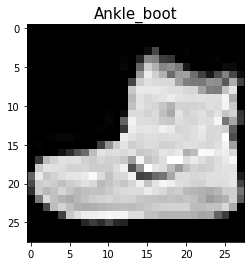


Ankle_boot


In [7]:
# plt로 형태를 출력해보자

plt.imshow(train_images[0], cmap='gray')
plt.title(idx2label(train_labels[0]), size=15)
plt.show()
print('')
print(idx2label(train_labels[0]))

In [8]:
# 이걸 함수로 만들어 볼까

def train_show(idx) :
  plt.imshow(train_images[idx], cmap='gray')
  plt.title(idx2label(train_labels[idx]), size=20)
  plt.show()

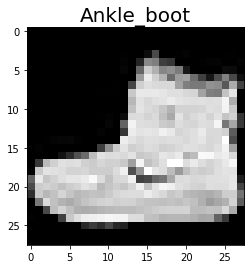

In [9]:
train_show(0)

In [10]:
# train images에서 0이 아닌 값들을 찾아보자

train_images[train_images != 0]

array([ 1, 13, 73, ..., 42, 21, 18], dtype=uint8)

In [11]:
# 이미지의 값이 가장 큰 idx 와 가장 작은 idx를 찾아보자
train_images.reshape((60000,-1)).shape

(60000, 784)

In [12]:
print(train_images.reshape((60000,-1)).sum(axis=1).argmax()) #최대값
print(train_images.reshape((60000,-1)).sum(axis=1).argmin()) #최소값

55023
9230


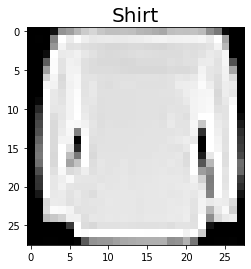

In [13]:
train_show(train_images.reshape((60000,-1)).sum(axis=1).argmax())

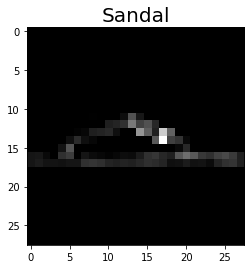

In [14]:
train_show(train_images.reshape((60000,-1)).sum(axis=1).argmin())

## PreProcessing

In [15]:
# Train, Test 이미지 데이터 범위 확인
print(train_images.max(), train_images.min())
print(test_images.max(), test_images.min())

255 0
255 0


In [16]:
print(train_images.dtype)
print(test_images.dtype)

uint8
uint8


In [17]:
train_images = train_images.astype(np.float64)
test_images = test_images.astype(np.float64)

In [18]:
# 데이터 정규화

train_images = train_images / 255
test_images = test_images / 255

In [19]:
# 함수로 구현하면 이런 느낌
def norm(data) :
  min_v = data.min()
  max_v = data.max()
  return (data - min_v)/(max_v - min_v)

In [20]:
norm(train_images).min(), norm(train_images).max()

(0.0, 1.0)

## Visualizing

### random

In [ ]:
# 랜덤으로 n장을 가져오고 그것의 plt를 그린 후 label까지 불러와보자.
def draw(n) : 
  label_list = []
  idx = list(np.random.randint(0,60001,n))
  pic_n = train_images[idx].transpose((1,0,2)).reshape((28,-1))
  plt.figure(figsize=(10+(n/2), 12))
  plt.imshow(pic_n,cmap='gray')
  plt.show()

  for i in idx :
    label_list.append(idx2label(train_labels[i]))
  print('')
  for j in label_list :
    print(j, sep=' ', end= ' ')
#train_images[list(np.random.randint(0,60000,5))].shape
#np.random.randin

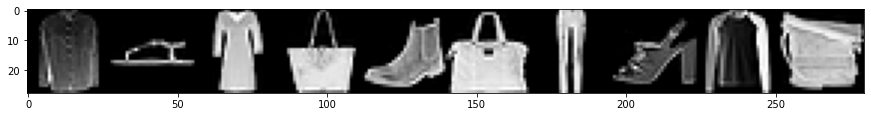


Shirt Sandal Dress Bag Ankle_boot Bag Trouser Sandal Pullover Bag 

In [ ]:
draw(10)

### Standard

In [ ]:
# (5,28,28) 획득하기
train_images[:5].shape

(5, 28, 28)

In [ ]:
# (28,28*5)로 변환하자
train_images[:5].transpose((1,0,2)).reshape((28,-1)).shape

(28, 140)

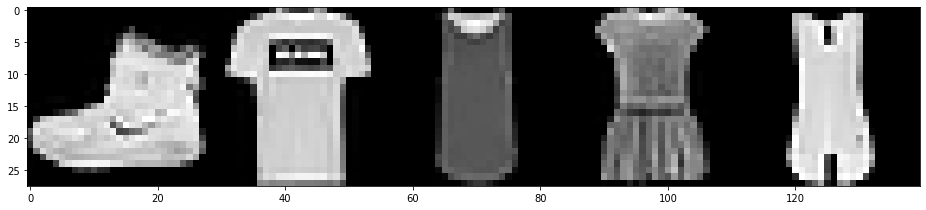

In [ ]:
plt.figure(figsize=(16,12))
plt.imshow(train_images[:5].transpose((1,0,2)).reshape((28,-1)),cmap='gray')
plt.show()


In [ ]:
# 레이블에 따라 5개를 출력하는 함수를 만들어보자
# argwhere을 사용하자
np.argwhere(train_labels == 7)[:5,...,0] # 뒤에 ...,0은 펴주는 역할을 수행함

array([ 6, 14, 41, 46, 52])

In [ ]:
train_images[np.argwhere(train_labels == 7)[:5,...,0]].transpose((1,0,2)).reshape(28,-1).shape

(28, 140)

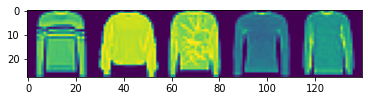

In [ ]:
plt.imshow(train_images[np.argwhere(train_labels == 2)[:5,...,0]].transpose((1,0,2)).reshape(28,-1))
plt.show()

## Data Augmentation
 - 이미지 확대 및 다객체 추가 방법

In [21]:
# 이미지 한장의 크기를 4배로 확대하고, 객체는 4분면 영역중 랜덤으로 1공간에 넣는 함수를 작성해보자

def expand(img) :
  bg = np.zeros(img.shape)
  # 1 0
  # 2 3
  idx = np.random.randint(0,4)
  slots = [bg,bg,bg,bg]
  slots[idx] = img
  expanded = np.vstack([
                        np.hstack(slots[:2]), 
                        np.hstack(slots[2:])
                        
  ]
  )
  return expanded

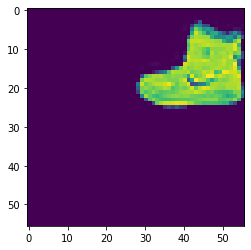

In [ ]:
plt.imshow(expand(train_images[0]))

In [ ]:
expand(train_images[0]).shape

(56, 56)

In [22]:
# 전체 training셋과 test셋에 적용해보자.
train_expand_images = np.array([expand(img) for img in train_images])
test_expand_images = np.array([expand(img) for img in test_images])

In [23]:
train_expand_images.shape, test_expand_images.shape

((60000, 56, 56), (10000, 56, 56))

In [ ]:
# 4배 이미지 변환함수를 수정하여 이미지 사이즈를 4배 확대 후 객체를 랜덤으로 0~4개 랜덤 4분면에 위치시키는 함수를 만들어보자
# 이 과정을 수행하고 나면 하나의 그림에 여러 그림이 들어 갈 수 있으므로 라벨링을 다르게 해줘야 함.
# 그래서 인자가 두 개 필요함
'''
def expand_2(x,y) :

  images = []
  labels = []

  for _ in range(4) :
    bg = np.zeros((28,28))
    idx = np.random.randint(0,5)

    label = np.zeros((10,)) #[0,0,0,.....] 
    slots = [bg, bg, bg, bg]
    
  



  bg = np.zeros(img.shape)
  # 1 0
  # 2 3
  idx = np.random.randint(0,4)
  slots = [bg,bg,bg,bg]
  slots[idx] = img
  expanded = np.vstack([
                        np.hstack(slots[:2]), 
                        np.hstack(slots[2:])
                        
  ]
  )
  return expanded
  '''

'\ndef expand_2(x,y) :\n\n  images = []\n  labels = []\n\n  for _ in range(4) :\n    bg = np.zeros((28,28))\n    idx = np.random.randint(0,5)\n\n    label = np.zeros((10,)) #[0,0,0,.....] \n    slots = [bg, bg, bg, bg]\n    \n  \n\n\n\n  bg = np.zeros(img.shape)\n  # 1 0\n  # 2 3\n  idx = np.random.randint(0,4)\n  slots = [bg,bg,bg,bg]\n  slots[idx] = img\n  expanded = np.vstack([\n                        np.hstack(slots[:2]), \n                        np.hstack(slots[2:])\n                        \n  ]\n  )\n  return expanded\n  '

In [24]:
from tensorflow.keras.utils import to_categorical

In [ ]:
def multi_plot(x,y,iterations=3) :
  for iter in range(iterations) :
  
    bg = np.zeros((28,28))
    quad = [0, 1, 2, 3]  # 4분면
    pick = np.random.randint(1,5) # 몇 개를 뽑을 지 랜덤으로 정한다 # 최소 1개는 나오게하자;;
    pic_bg = list(np.random.choice(quad,pick, replace=False)) # 그림이 그려질 사분면
    pic_n  = list(np.random.choice(range(x.shape[0]),pick, replace=False)) # 그림을 미리 뽑는다.
    slots = [bg, bg, bg, bg]

    labels = np.zeros((10,))
    for a,b in zip(pic_bg, pic_n) :
      slots[a] = x[b]
      labels += to_categorical(y[b],10)

    picture = np.vstack([
                        np.hstack(slots[:2]),
                        np.hstack(slots[2:])
    ])


    labels[labels >=1 ] = 1
    plt.imshow(picture)
    plt.show()
    print(labels)
    for idx in list(np.argwhere(labels==1).reshape(-1)) :
      print(idx2label(idx))
    print('\n')
  #return picture, labels

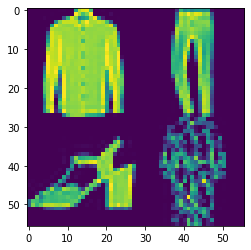

[0. 1. 0. 0. 1. 1. 1. 0. 0. 0.]
Trouser
Coat
Sandal
Shirt




In [ ]:
multi_plot(train_images, train_labels,1)

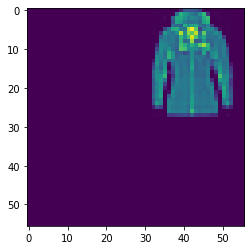

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Coat




In [ ]:
multi_plot(test_images, test_labels,1)

In [ ]:
# ploting말고 값을 출력하는 함수를 다시 만들어보자
def expand_bc(x,y) :
  bg = np.zeros(x.shape[1:3])
  quad = [0,1,2,3]
  pick = np.random.randint(1,5)
  pic_bg = list(np.random.choice(quad,pick, replace=False))
  pic_n  = list(np.random.choice(range(x.shape[0]),pick, replace=False))
  slots = [bg, bg, bg, bg]

  labels = np.zeros((len(np.unique(y)),))

  for a,b in zip(pic_bg, pic_n) :
    slots[a] = x[b]
    labels += to_categorical(y[b],len(np.unique(y)))
  
  labels[labels >=1] =1
  labels = labels.astype(int)
  picture = np.vstack([
                        np.hstack(slots[:2]),
                        np.hstack(slots[2:])
    ])
  return picture, labels


In [ ]:
h = expand_bc(train_images, train_labels)

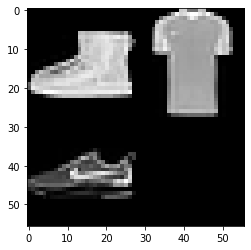

In [ ]:
plt.imshow(h[0],cmap='gray')
plt.show()

In [25]:
# 4배 이미지 변환을 전체 train/ test 데이터에 실행하여 train_multi_images, train_multi_labels, test_multi_images, test_multi_labels 를 생성하자

train_multi_images, train_multi_labels = list(zip(*[expand_bc(train_images, train_labels) for i in train_images]))
test_multi_images, test_multi_labels = list(zip(*[expand_bc(test_images, test_labels) for i in test_images]))

NameError: ignored

In [26]:
# 위에 꺼 돌리는데 15분 13초 걸렸다... 뭔가 좀 이상하다...
# 함수를 다르게 한번 짜보자

def expand_4times(x_data,y_data) :
  images = []
  labels = []

  for _ in range(4) :
    bg = np.zeros((28,28))
    obj_count = np.random.randint(0,5)

    label = np.zeros((10,))
    slots = [bg, bg,bg,bg]

    for idx in range(obj_count) :
      i = np.random.randint(len(x_data))
      slots[idx] = x_data[i]
      label += tf.keras.utils.to_categorical(y_data[i],10)
    
    np.random.shuffle(slots)
  
  new_img = np.vstack([
                       np.hstack(slots[:2]),
                       np.hstack(slots[2:])
  ])

  images.append(new_img)
  labels.append((label >=1).astype(np.int))
  return np.array(images), np.array(labels)

In [27]:
train_multi_images, train_multi_labels = list(zip(*[expand_4times(train_images, train_labels) for i in train_images]))
test_multi_images, test_multi_labels = list(zip(*[expand_4times(test_images, test_labels) for i in test_images]))

In [ ]:
# 뭐지 14초가 걸렸다.... 뭐가 문제일까...

In [28]:
np.array(train_multi_images).shape # 뭐여 중간에1 이 껴있네

(60000, 1, 56, 56)

In [29]:
np.array(train_multi_images)[...,0, :, :].shape

(60000, 56, 56)

In [30]:
# 이렇게 표시하는게 더 이해하기 쉬움
np.array(train_multi_images)[:,0,:,:].shape

(60000, 56, 56)

In [31]:
np.array(train_multi_labels).shape # 얘도 바꿔주자

(60000, 1, 10)

In [32]:
np.array(train_multi_labels)[:,0,:].shape

(60000, 10)

In [33]:
# 데이터셋을 재정의하자
train_multi_images = np.array(train_multi_images)[:,0,:,:].reshape(-1,56,56,1)
train_multi_labels = np.array(train_multi_labels)[:,0,:]

test_multi_images = np.array(test_multi_images)[:,0,:,:].reshape(-1,56,56,1)
test_multi_labels = np.array(test_multi_labels)[:,0,:]

In [34]:
train_multi_images.shape, test_multi_images.shape

((60000, 56, 56, 1), (10000, 56, 56, 1))

In [35]:
# 개수에 따라 연속된 그림을 보여주는 함수를 작성해보자
def filter(obj_count, count=5) :
  labels = train_multi_labels.sum(axis=1)
  ids = np.argwhere( labels == obj_count)[:count,0]

  imgs = train_multi_images[ids][...,0].transpose((1,0,2)).reshape(56,-1)
  plt.imshow(imgs)
  plt.show()

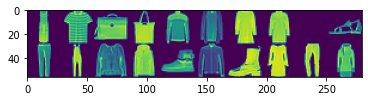

In [ ]:
filter(3,5)

In [ ]:
# multi label와 train label 차이
train_labels[0]

9

In [ ]:
train_multi_labels[3]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0])

In [ ]:
list(range(0,10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

<BarContainer object of 10 artists>

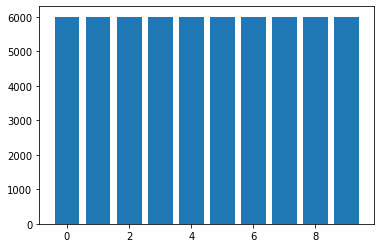

In [36]:
# train label에서 label 들의 분포를 히스토그램으로 보자
plt.bar(list(range(0,10)), to_categorical(train_labels).sum(axis=0))

# 고르게 분포되있음.


<BarContainer object of 10 artists>

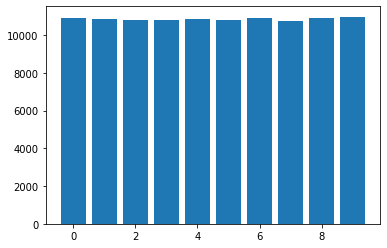

In [37]:
# 멀티레이블의 분포도 봐보자

plt.bar(list(range(10)), train_multi_labels.sum(axis=0))

(array([11986.,     0., 13476.,     0.,     0., 14570.,     0., 13957.,
            0.,  6011.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

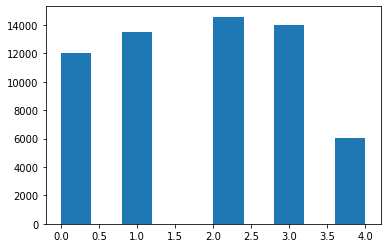

In [38]:
# multi images에서 평균 사진의 개수 분포를 구해보자
plt.hist(train_multi_labels.sum(axis=1))

## Modeling
 - Transfer Learning
   - 학습을 시킨 후 학습한 내용을 바탕으로 다른 모델을 학습시키는 방법

In [39]:
 # train_expand_images, train_labels로 싱글 label을 처리하는 모델을 생성해보자
from keras.layers import Input, MaxPool2D, Conv2D, Dropout, Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model

In [40]:
def single_model() :
  with tf.device('/device:GPU:0'):
    input = Input((56,56,1))
    x = Conv2D(16, 2, padding='same',activation='relu')(input)
    x = MaxPool2D(2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(32, 2, padding='same',activation='relu')(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, 2, padding='same',activation='relu')(x)
    x = MaxPool2D(2)(x)
    #x = Flatten()(x) # 요건 모델1
    x = GlobalAveragePooling2D()(x) #요건 모델2
    x = Dense(10, activation = 'softmax')(x)

    return Model(input,x)

In [41]:
model2 = single_model()
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 56, 56, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 56, 16)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0     

In [ ]:
model2 = single_model()
model2.summary() #보면 파라미터가 많이 줄었다.

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 56, 56, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 16)        80        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        2080      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0   

In [42]:
# 만든 모델에 loss 와 optimizer, metric을 설정하자
model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [43]:
train_expand_images.shape
# shape이 다르기 때문에 뒤에 1을 붙여주자


(60000, 56, 56)

In [44]:
# 모델 학습시키자
hist = model2.fit(train_expand_images.reshape((-1,56,56,1)),
                  to_categorical(train_labels,10),
                  
                  validation_data = (test_expand_images.reshape((-1,56,56,1)),
                                     to_categorical(test_labels,10))
                  ,epochs=15, verbose=1)

Epoch 1/15
1875/1875 [==============================] - 41s 5ms/step - loss: 1.7063 - accuracy: 0.3667 - val_loss: 1.0247 - val_accuracy: 0.6283
Epoch 2/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.9603 - accuracy: 0.6515 - val_loss: 0.8372 - val_accuracy: 0.6951
Epoch 3/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.8230 - accuracy: 0.7015 - val_loss: 0.7428 - val_accuracy: 0.7359
Epoch 4/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.7563 - accuracy: 0.7286 - val_loss: 0.6726 - val_accuracy: 0.7662
Epoch 5/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6919 - accuracy: 0.7480 - val_loss: 0.6333 - val_accuracy: 0.7725
Epoch 6/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6592 - accuracy: 0.7616 - val_loss: 0.6076 - val_accuracy: 0.7812
Epoch 7/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6299 - accuracy: 0.7790 - val_loss: 0.5791 - val_accuracy

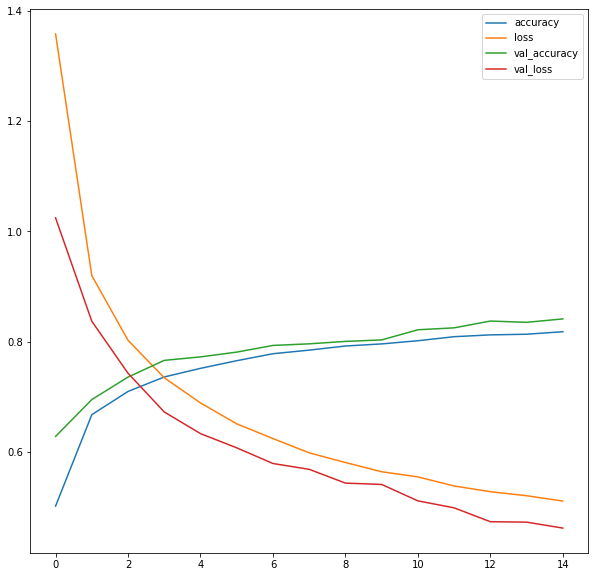

In [45]:
plt.figure(figsize=(10,10))
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

## 결과확인

In [ ]:
test_expand_images.shape

(10000, 56, 56)

In [46]:
# 완성된 모델에서 test_expand_image 중 1장을 넣고 결과를 받아보자
res = model2.predict(test_expand_images[0].reshape((1,56,56,1)) )
res.shape

(1, 10)

Ankle_boot


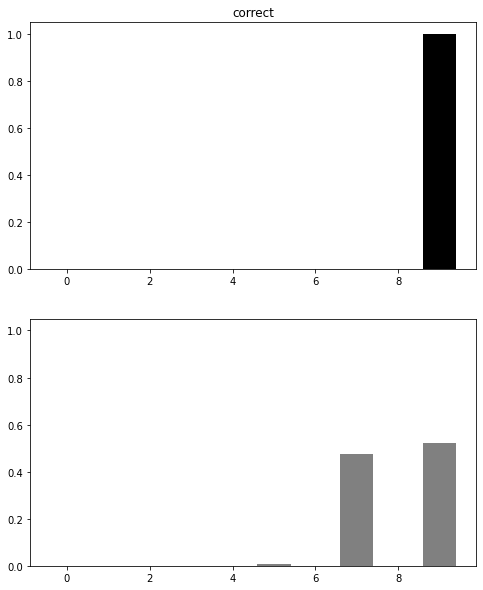

In [49]:
plt.figure(figsize=(8,10))
plt.subplot(211)
plt.bar(np.arange(0,10), to_categorical((test_labels)[0],10), color='black')
plt.title('correct')

plt.subplot(212)
plt.bar(np.arange(0,10), res[0], color='gray')
plt.ylim(0,1.05)
print(idx2label(test_labels[0]))

plt.show()

Pullover


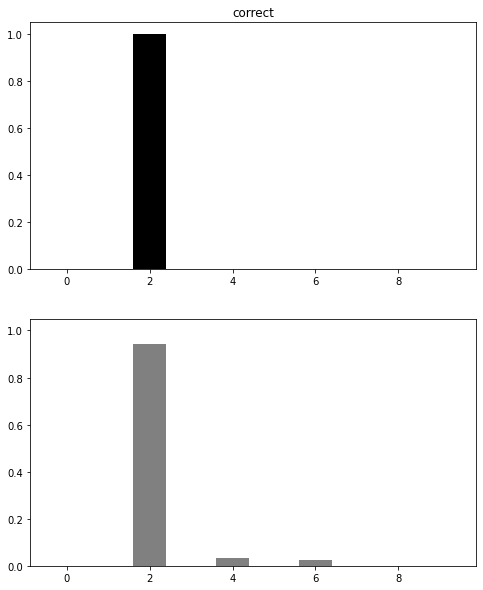

In [50]:
res = model2.predict(test_expand_images[1].reshape((1,56,56,1)) )
plt.figure(figsize=(8,10))
plt.subplot(211)
plt.bar(np.arange(0,10), to_categorical((test_labels)[1],10), color='black')
plt.title('correct')

plt.subplot(212)
plt.bar(np.arange(0,10), res[0], color='gray')
plt.ylim(0,1.05)
print(idx2label(test_labels[1]))

plt.show()

Ankle_boot


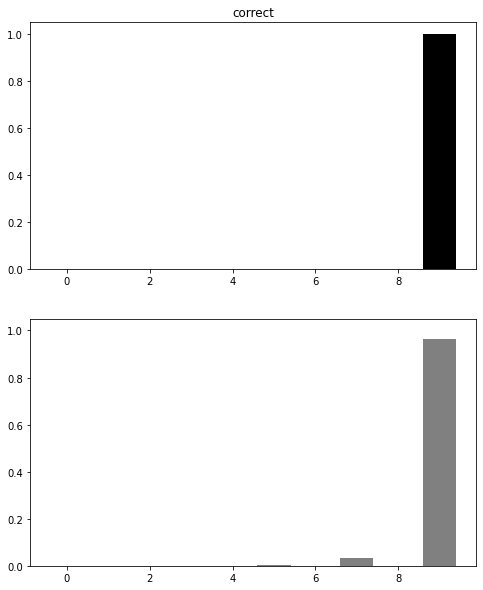

In [51]:
res = model2.predict(test_expand_images[1227].reshape((1,56,56,1)) )
plt.figure(figsize=(8,10))
plt.subplot(211)
plt.bar(np.arange(0,10), to_categorical((test_labels)[1227],10), color='black')
plt.title('correct')

plt.subplot(212)
plt.bar(np.arange(0,10), res[0], color='gray')
plt.ylim(0,1.05)
print(idx2label(test_labels[1227]))

plt.show()

## 멀티 레이블 모델링

In [52]:
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 56, 56, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 56, 16)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0     

In [53]:
# train_multi_images와 train_multi_lables를 처리할 수 있는 모델을 만들어보자
# 기존 모델을 가져와서 진행 예정 
def multi_model (model) :
  model.trainable = False # 너 모델 학습 잘됐어 수정하지마 라는 의미 역전파 시행하여도 weight 수정이 되지 않음.
  x = model.layers[-2].output
  x = Dense(10, activation='sigmoid')(x)

  return Model(model.input, x)

In [54]:
new_model = multi_model(model2)
new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 56, 56, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 56, 16)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0   

In [55]:
new_model.get_weights()[0]

array([[[[ 0.07509968,  0.7241183 ,  0.8498789 , -0.71425045,
          -0.7418599 , -0.05057143,  0.7264793 , -0.13088961,
           0.61993873,  1.4299874 ,  0.7103593 , -0.06208993,
           0.17813846,  0.9216411 ,  0.5498259 ,  0.64598894]],

        [[-0.36587244,  1.4621361 ,  1.8143065 ,  0.777738  ,
          -0.8423796 ,  1.8089592 ,  0.19632111,  0.32513964,
           0.90779924,  1.0596379 , -0.5966942 , -0.07960649,
           1.5603406 ,  0.44148946,  1.9235626 , -2.0591471 ]]],


       [[[ 1.4623859 ,  0.2114549 ,  0.14156102, -0.9053699 ,
           0.75449044, -0.45001152, -3.944142  ,  1.2266393 ,
          -0.54516065,  0.88848585,  0.72626376, -0.24902269,
           0.3093506 , -2.258917  ,  0.27785236,  1.1388193 ]],

        [[ 1.1749119 ,  0.89508003, -0.06790058,  0.8953562 ,
           0.74808836,  0.959582  , -4.941737  ,  1.2745919 ,
          -1.1380639 , -0.7578339 , -0.6969142 , -0.20496078,
           0.837063  , -3.5326655 , -0.04509738, -2.068165 

In [56]:
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# train multi image를 학습해보자

hist2 = new_model.fit(train_multi_images, train_multi_labels,
                      validation_data = (test_multi_images, test_multi_labels),
                      epochs = 15,
                      verbose = 1)

Epoch 1/15
1875/1875 [==============================] - 7s 4ms/step - loss: 7.2814 - accuracy: 0.0863 - val_loss: 4.2165 - val_accuracy: 0.1599
Epoch 2/15
1875/1875 [==============================] - 7s 3ms/step - loss: 4.3941 - accuracy: 0.2303 - val_loss: 4.0454 - val_accuracy: 0.2228
Epoch 3/15
1875/1875 [==============================] - 7s 3ms/step - loss: 4.1348 - accuracy: 0.3809 - val_loss: 3.9763 - val_accuracy: 0.2418
Epoch 4/15
1875/1875 [==============================] - 7s 3ms/step - loss: 4.0696 - accuracy: 0.4194 - val_loss: 3.8427 - val_accuracy: 0.2759
Epoch 5/15
1875/1875 [==============================] - 7s 4ms/step - loss: 4.0609 - accuracy: 0.4013 - val_loss: 3.9441 - val_accuracy: 0.2946
Epoch 6/15
1875/1875 [==============================] - 6s 3ms/step - loss: 4.1135 - accuracy: 0.4235 - val_loss: 3.9387 - val_accuracy: 0.3017
Epoch 7/15
1875/1875 [==============================] - 7s 3ms/step - loss: 4.1632 - accuracy: 0.4452 - val_loss: 4.0902 - val_accuracy:

In [35]:
# 성능이 뭔가 안좋아진것같다..
res = new_model.predict(test_multi_images[0].reshape((1,56,56,1)))
res.shape

(1, 10)

In [51]:
def final(n) :
  res = model2.predict(test_multi_images[n].reshape((1,56,56,1)) )


  plt.figure(figsize=(8,10))

  plt.subplot(311)
  plt.imshow(test_multi_images[n].reshape((56,56))) # 이미지

  plt.subplot(312)
  plt.bar(np.arange(0,10), test_multi_labels[n], color='black')
  plt.title('correct')

  plt.subplot(313)
  plt.bar(np.arange(0,10), res[0], color='gray')
  plt.ylim(0,1.05)


  plt.show()
  for idx in list(np.argwhere(test_multi_labels[n]==1).reshape(-1)) :
    print('')
    print(idx2label(idx))

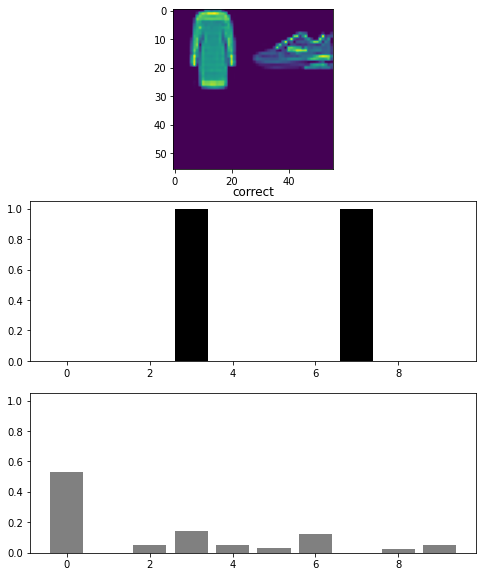


Dress

Sneaker


In [52]:
final(2)

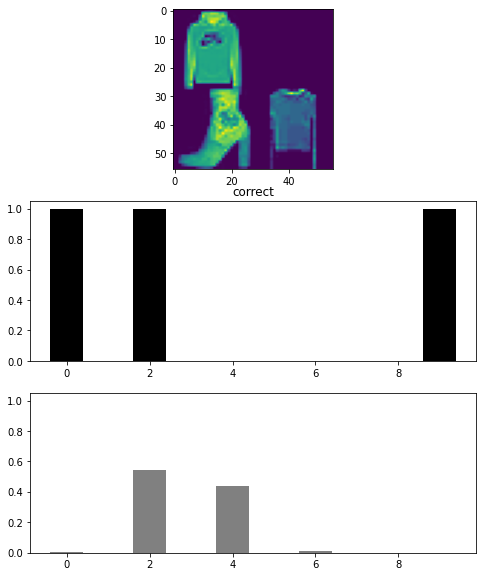


T-shirt/top

Pullover

Ankle_boot


In [53]:
final(1227)

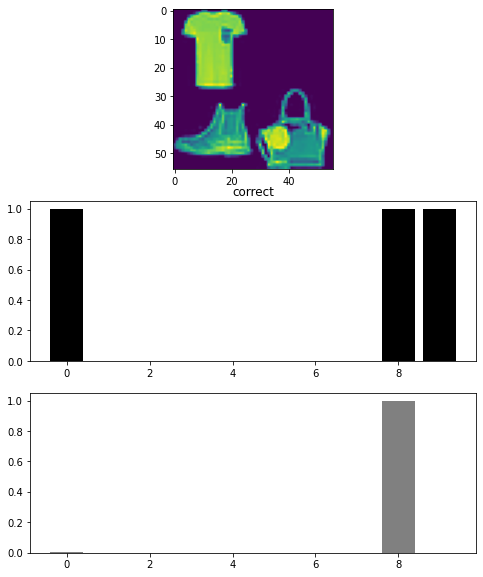


T-shirt/top

Bag

Ankle_boot


In [54]:
final(620)

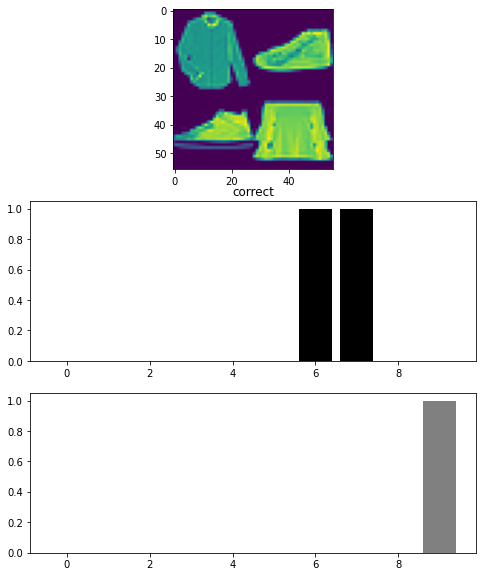


Shirt

Sneaker


In [55]:
final(426)

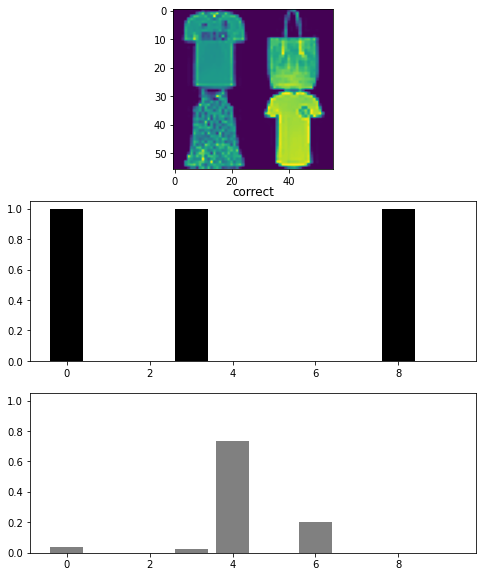


T-shirt/top

Dress

Bag


In [59]:
# 정말 안맞는걸 볼 수 있다...
final(5)

In [60]:
# for 문을 활용해서 돌려보자
epochs = 15
batch_size = 32
new_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
for epoch in range(epochs) :
  for _ in range(0, len(train_images), batch_size) : 
    batch_x = []
    batch_y = []

    for _ in range(batch_size) :
      x, y = expand_4times(train_images, train_labels)
      batch_x.append(x)
      batch_y.append(y)
    
    batch_x = np.array(batch_x).reshape((-1,56,56,1))
    batch_y = np.array(batch_y).reshape((-1,10))

    new_model.train_on_batch(batch_x, batch_y)
  
  print(epoch+1, 'epochs' )
      # 돌릴 때 마다 이미지를 새로 만드는 느낌임.

1 epochs
2 epochs
3 epochs
4 epochs
5 epochs
6 epochs
7 epochs
8 epochs
9 epochs
10 epochs
11 epochs
12 epochs
13 epochs
14 epochs
15 epochs


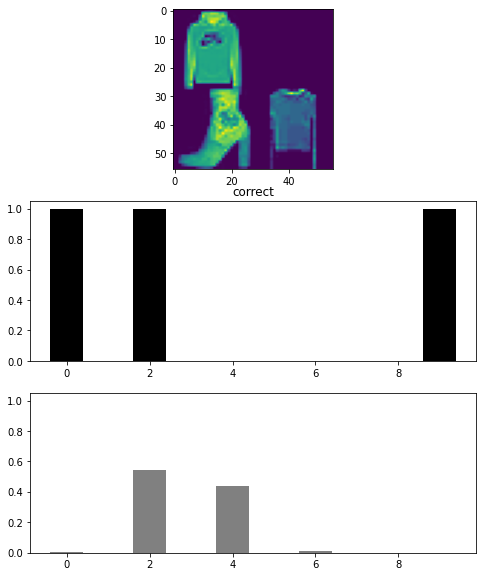


T-shirt/top

Pullover

Ankle_boot


In [62]:
final(1227)

In [70]:
test_multi_labels[8]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

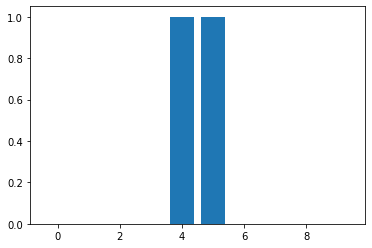

In [77]:
plt.bar(np.arange(0,10), test_multi_labels[16])
plt.show()

<BarContainer object of 10 artists>

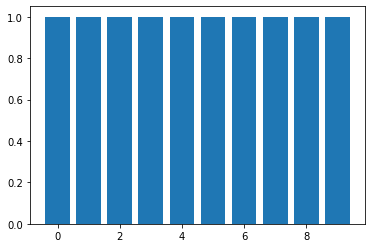

In [83]:
res = new_model.predict(test_multi_images[0].reshape((1,56,56,1)))
plt.bar(np.arange(0,10), res[0])

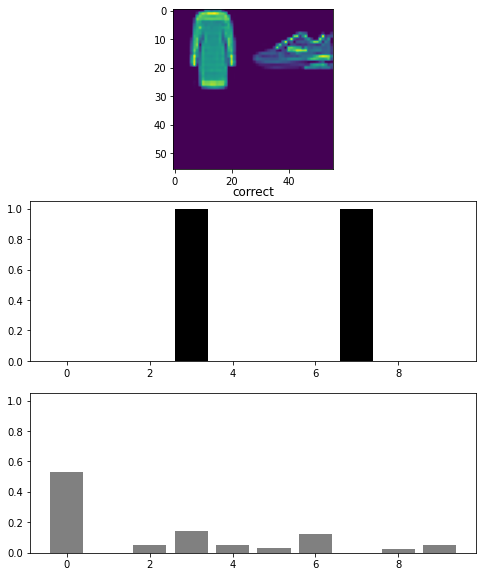


Dress

Sneaker


In [82]:
final(2)